In [41]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
os.getcwd()

'C:\\Users\\91939'

# Data Preparation (organizing the data)

In [15]:
#Changing the directory
os.chdir('C:\\Users\\91939\\dogs-vs-cats\\train')

## Segregating the dogs and cats images based on labels
# Checking if the directory not exists

if os.path.isdir('train/dog') is False:
    # make a dog folder in train folder
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    # make a valid folder and then dog folder in it
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    # make a test folder and then dog folder in it
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
    #We will use 1000 images for training , 200 for validation and 100 for testing
    
    # The images of cat are starting with cat and that of dogs are starting with dog
    
    # random.sample takes a list/array and a number (say k) as input and return k random 
    #elements from the list/array whatever is given
    
    # glob stands for global
    # glob.glob is something which we use to return all the files that has some common prefix
    # or pattern in the current directory
    # Make sure that yiu have set the current directory 
    
    # Shutil is used copy or remove or shift files 
    # for this too don't forget to set the current directoy
    
    for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('cat*'), 100):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('dog*'), 100):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, 'test/dog')
os.chdir('../../')    

In [31]:
train_path = 'C:\\Users\\91939\\dogs-vs-cats\\train'
valid_path = 'C:\\Users\\91939\\dogs-vs-cats\\valid'
test_path = 'C:\\Users\\91939\\dogs-vs-cats\\test'

# Image Augmentation

Image augmentation is a technique of applying different transformations to original images which results in multiple transformed copies of the same image. Each copy, however, is different from the other in certain aspects depending on the augmentation techniques you apply like shifting, rotating, flipping, etc.

We will be using the ImageDataGenerator from keras inorder to augment the images while the model is learning 

We need to give the preprocessing function and then other details to the ImageDataGenerator

The flow_from_directory() method allows you to read the images directly from the directory and augment them while the neural network model is learning on the training data.

The method expects that images belonging to different classes are present in different folders but are inside the same parent folder.



In [185]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=None) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=100, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [45]:
train_batches # This is a Directory iterator

# Visualize The Data

We now call next(train_batches) to generate a batch of images and labels from the training set. Note that the size of this batch is determined by the batch_size we set when we created train_batches.

In [36]:
imgs, labels = next(train_batches)

In [170]:
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

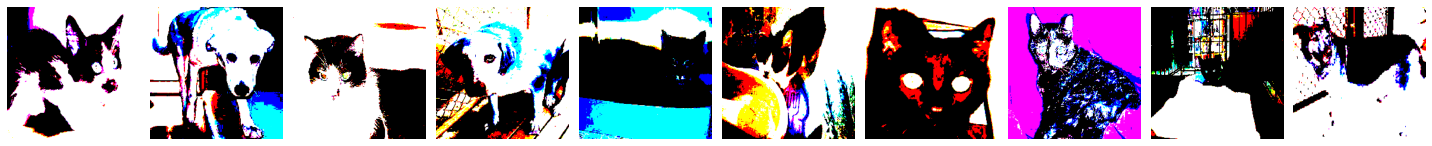

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [43]:
plotImages(imgs)
print(labels)

# Whatever the color distortion is taking place its becuz of the vgg16 preprocessing function which 
# we used in the ImageDataGenerator

In the above lables we see one hot encoded output int the form of [x,y] where x represents cat and y represents dog.Dogs are represented with the one-hot encoding of [0,1], and cats are represented by [1,0].

# Building a CNN

The first layer in the model is a 2-dimensional convolutional layer. This layer will have 32 output filters each with a kernel size of 3x3, and we'll use the relu activation function.

Note that the choice for the number of output filters specified is arbitrary, and the chosen kernel size of 3x3 is generally a very common size to use.

We enable zero-padding by specifying padding = 'same'.

On the first layer only, we also specify the input_shape, which is the shape of our data. Our images are 224 pixels high and 224 pixels wide and have 3 color channels: RGB. This gives us an input_shape of (224,224,3).

We then add a max pooling layer to pool and reduce the dimensionality of the data.

We follow this by adding another convolutional layer with the exact specs as the earlier one, except for this second Conv2D layer has 64 filters. The choice of 64 here is again arbitrary, but the general choice of having more filters in later layers than in earlier ones is common. This layer is again followed by the same type of MaxPool2D layer.

We then Flatten the output from the convolutional layer and pass it to a Dense layer. This Dense layer is the output layer of the network, and so it has 2 nodes, one for cat and one for dog. We'll use the softmax activation function on our output so that the output for each sample is a probability distribution over the outputs of cat and dog.

In [47]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

We can check out a summary of the model by calling model.summary().

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
________________________________________________

# Compiling the model

Now  the model is built, we compile the model using the Adam optimizer (an arbitrary choice) with a learning rate of 0.0001 (again a random choice) , a loss of categorical_cross_entropy, and we'll look at accuracy as our performance metric

In [50]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=['accuracy'])

Using binary vs non binary in the output.

When we have only two classes, we could instead configure our output layer to have only one output, rather than two, and use binary_crossentropy as our loss, rather than categorical_crossentropy. Both options work equally well and achieve the exact same result.

With binary_crossentropy, however, the last layer would need to use sigmoid, rather than softmax, as its activation function.

# Training the neural network
 We'll be using the fit function now, we'll be passing in  DirectoryIterators train_batches and valid_batches to train and validate the model.

In [51]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
100/100 - 40s - loss: 14.5291 - accuracy: 0.5820 - val_loss: 5.2859 - val_accuracy: 0.6150
Epoch 2/10
100/100 - 40s - loss: 4.3627 - accuracy: 0.7170 - val_loss: 7.7495 - val_accuracy: 0.6000
Epoch 3/10
100/100 - 39s - loss: 0.9763 - accuracy: 0.8620 - val_loss: 3.9412 - val_accuracy: 0.6150
Epoch 4/10
100/100 - 39s - loss: 0.2161 - accuracy: 0.9490 - val_loss: 4.0917 - val_accuracy: 0.5950
Epoch 5/10
100/100 - 38s - loss: 0.0552 - accuracy: 0.9790 - val_loss: 3.1784 - val_accuracy: 0.6100
Epoch 6/10
100/100 - 35s - loss: 0.0184 - accuracy: 0.9950 - val_loss: 3.3887 - val_accuracy: 0.6050
Epoch 7/10
100/100 - 37s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 3.4666 - val_accuracy: 0.6100
Epoch 8/10
100/100 - 36s - loss: 8.9767e-04 - accuracy: 1.0000 - val_loss: 3.2142 - val_accuracy: 0.6150
Epoch 9/10
100/100 - 35s - loss: 3.4456e-04 - accuracy: 1.0000 - val_loss: 3.2191 - val_accuracy: 0.6200
Epoch 10/10
100/100 - 38s - loss: 2.9366e-04 - accuracy: 1.0000 - val_loss: 3.2222

From this output, we can see the performance of this simple model on the training set is great, with accuracy reaching 100% and loss nearing 0, however, by comparing these results to the validation metrics, we can see that our model is vastly overfitting to the training data.

# Predicting On The Test Data

In [52]:
test_imgs, test_labels = next(test_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

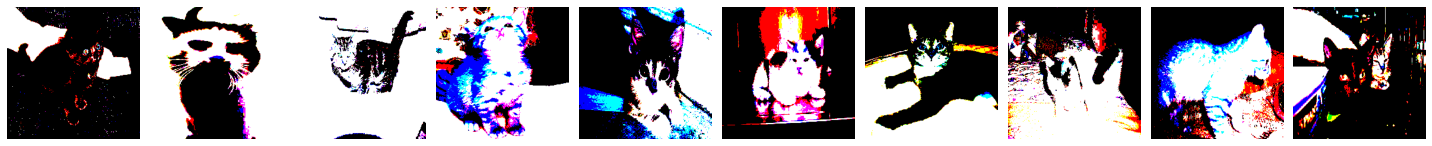

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [53]:
plotImages(test_imgs)
print(test_labels)

In [56]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
predictions[1:10]

array([[8.5056607e-05, 9.9991488e-01],
       [7.1026361e-01, 2.8973642e-01],
       [3.8818428e-03, 9.9611819e-01],
       [4.3315396e-01, 5.6684607e-01],
       [1.4396530e-01, 8.5603476e-01],
       [1.9075391e-01, 8.0924612e-01],
       [9.9999297e-01, 7.0928609e-06],
       [9.9599540e-01, 4.0045776e-03],
       [9.9943310e-01, 5.6691520e-04]], dtype=float32)

In [59]:
np.round(predictions)[1:10]

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# Plotting Predictions With A Confusion Matrix

In [60]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [62]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [64]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[19 31]
 [16 34]]


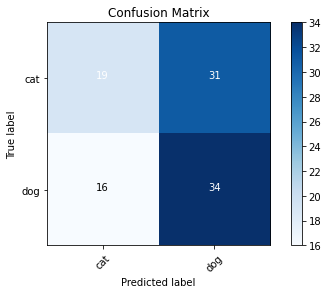

In [67]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Using a pretrained model (VGG16) which won the 2014 Imagenet competetion to classify the images 

We'll import this VGG16 model and then fine-tune it using Keras. The fine-tuned model will not classify images as one of the 1000 categories for which it was trained on, but instead it will only work to classify images as either cats or dogs.

Note that dogs and cats were included in the ImageNet library from which VGG16 was originally trained. Therefore, the model has already learned the features of cats and dogs. Given this, the fine-tuning we'll do on this model will be very minimal.

Fine-tuning is a way of applying or utilizing transfer learning. Specifically, fine-tuning is a process that takes a model that has already been trained for one given task and then tunes or tweaks the model to make it perform a second similar task.

# Why to fine tuning if we can build a model on our own

When building a model from scratch, we usually must try many approaches through trial-and-error.
For example, we have to choose how many layers we're using, what types of layers we're using, what order to put the layers in, how many nodes to include in each layer, decide how much regularization to use, what to set our learning rate as, etc.

-Number of layers

-Types of layers

-Order of layers

-Number of nodes in each layer

-How much regularization to use

-Learning rate

Preprocessing of the VGG16 model was subtracting the mean of RGB values from the respective channels 
for each pixel,this was the reason for color distortion
Note that VGG16 took 3-4 weeks of training time with most advanced GPUs

# Importing VGG16

In [68]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553476096/553467096 [==============================] - 68s 0us/step


The original trained VGG16 model, along with its saved weights and other parameters, is now downloaded onto our machine.

We can check out a summary of the model just to see what the architecture looks like.

In [69]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Notice that the last Dense layer of VGG16 has 1000 outputs. These outputs correspond to the 1000 categories in the ImageNet library.

Since we're only going to be classifying two categories, cats and dogs, we need to modify this model in order for it to do what we want it to do, which is to only classify cats and dogs.

Since we are working with a sequential model and the vgg16 is not a sequential model,we will convert it into a sequential model

We first create a new model of type Sequential. We then iterate over each of the layers in vgg16_model, except for the last layer(the output layer), and add each layer to the new Sequential model.

# Making the sequential model out of the pretrained model

In [70]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

We'll iterate over each of the layers in our new Sequential model and set them to be non-trainable. This freezes the weights and other trainable parameters in each layer so that they will not be trained or updated when we later pass in our images of cats and dogs.The reason we don't want to retrain these layers is because, as mentioned earlier, cats and dogs were already included in the original ImageNet library. 

In [71]:
for layer in model.layers:
    layer.trainable = False

# Adding the output layers
 we add our new output layer, consisting of only 2 nodes that correspond to cat and dog. This output layer will be the only trainable layer in the model.

In [72]:
model.add(Dense(units=2, activation='softmax'))

In [73]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

# Training a fine-tuned Neural Network With TensorFlow's Keras API

Compiling the model before we train

In [74]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

Now fitting the model , we will run it for 5 epochs

In [75]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=5
)

Epoch 1/5
100/100 [==============================] - 226s 2s/step - loss: 0.2823 - accuracy: 0.8810 - val_loss: 0.1149 - val_accuracy: 0.9400
Epoch 2/5
100/100 [==============================] - 225s 2s/step - loss: 0.0898 - accuracy: 0.9620 - val_loss: 0.0818 - val_accuracy: 0.9550
Epoch 3/5
100/100 [==============================] - 225s 2s/step - loss: 0.0567 - accuracy: 0.9780 - val_loss: 0.0644 - val_accuracy: 0.9750
Epoch 4/5
100/100 [==============================] - 225s 2s/step - loss: 0.0380 - accuracy: 0.9850 - val_loss: 0.0590 - val_accuracy: 0.9800
Epoch 5/5
100/100 [==============================] - 226s 2s/step - loss: 0.0268 - accuracy: 0.9930 - val_loss: 0.0551 - val_accuracy: 0.9800


The most noticeable improvement is that this model is generalizing very well to the validation data, unlike the CNN we build from scratch previously.We can notice that the model has got an accuracy of 99.3% on training datasets and 98% accuracy on validation datasets

# Predicting using the model we trained

In [154]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [172]:
plotImages(deprocess_img(next(test_batches)[0]))

In [177]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
predictions[1:10]

array([[9.9999392e-01, 6.0553716e-06],
       [9.9863309e-01, 1.3669424e-03],
       [9.9962306e-01, 3.7696300e-04],
       [9.9999475e-01, 5.2656801e-06],
       [9.9998629e-01, 1.3663883e-05],
       [9.9999952e-01, 4.3135418e-07],
       [5.9486097e-01, 4.0513906e-01],
       [9.9850106e-01, 1.4989604e-03],
       [9.9991298e-01, 8.7008091e-05]], dtype=float32)

In [176]:
np.argmax(predictions, axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [196]:
imgs = deprocess_img(next(test_batches)[0])
# plotImages(imgs)
imgs_lables = np.argmax(predictions, axis=-1)
c = list(zip(imgs, imgs_lables))
random.shuffle(c)
imgs, imgs_lables = zip(*c)


In [203]:
def plotImages_with_lables(images_arr,lables_arr):
    plt.figure(figsize=(30,20))
    lables_list=[]
    for i in range(20):
        if lables_arr[i]==0:
            lables_list.append('Cat')
        else:
            lables_list.append('Dog')
        plt.subplot(4,5,i+1)
        plt.title('This is a '+lables_list[i])
        plt.imshow(images_arr[i])


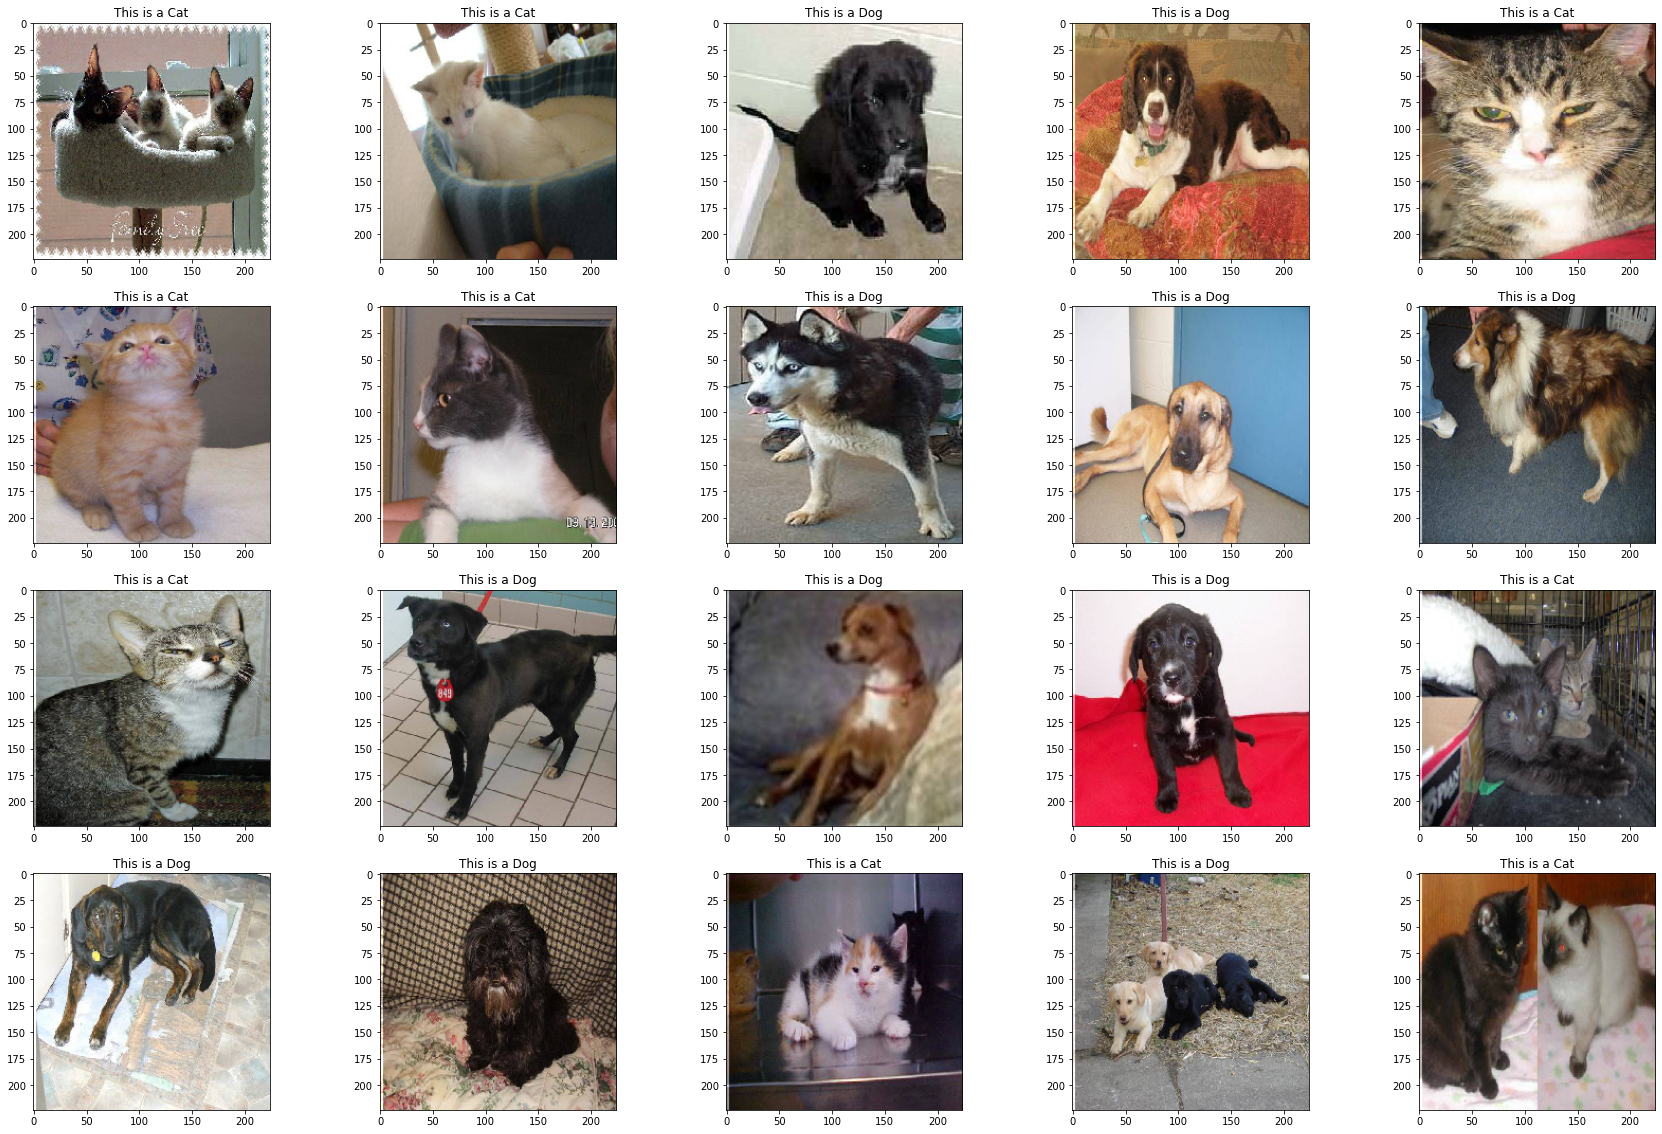

In [204]:
plotImages_with_lables(imgs, imgs_lables)